# Bungee Dunk Revisited

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey, (License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/))

Revised, Mike Augspurger (2021-present)

In [81]:
# import functions from modsim
import sys
sys.path.append('..\\..\\ModSimPy_Directory')
from ModSimPy_Functions.modsim import *

import pandas as pd

In the previous case study, we simulated a bungee jump with a model that took into account gravity, air resistance, and the spring force of the bungee cord, but we ignored the weight of the cord.

It is tempting to say that the weight of the cord doesn't matter because it falls along with the jumper.  But that intuition is incorrect, as explained by [Heck, Uylings, and Kędzierska](http://iopscience.iop.org/article/10.1088/0031-9120/45/1/007).  As the cord falls, it transfers energy to the jumper.   They derive a differential equation that relates the acceleration of the jumper to position and velocity:

$a = g + \frac{\mu v^2/2}{\mu(L+y) + 2L}$ 

where $a$ is the net acceleration of the jumper, $g$ is acceleration due to gravity, $v$ is the velocity of the jumper, $y$ is the position of the jumper relative to the starting point (usually negative), $L$ is the length of the cord, and $\mu$ is the mass ratio of the cord and jumper.

How does the behavior of the system change as we vary the mass of the cord? How does the acceleration change as the jumper falls? When the mass of the cord equals the mass of the jumper, what is the net effect on the lowest point in the jump?

If you don't believe this model is correct, [this video might convince you](https://www.youtube.com/watch?v=X-QFAB0gEtE).

Following the previous case study, we'll model the jump with the following assumptions:

1. Initially the bungee cord hangs from a crane with the attachment point 80 m above a cup of tea.

2. Until the cord is fully extended, it applies a force to the jumper as explained above.

3. After the cord is fully extended, it obeys [Hooke's Law](https://en.wikipedia.org/wiki/Hooke%27s_law); that is, it applies a force to the jumper proportional to the extension of the cord beyond its resting length.

4. The jumper is subject to drag force proportional to the square of their velocity, in the opposite of their direction of motion.

First I'll create a `params` object to contain the quantities we'll need:

1. Let's assume that the jumper's mass is 75 kg and the cord's mass is also 75 kg, so `mu=1`.

2. The jumpers's frontal area is 1 square meter, and terminal velocity is 60 m/s.  I'll use these values to back out the coefficient of drag.

3. The length of the bungee cord is `L = 25 m`.

4. The spring constant of the cord is `k = 40 N / m` when the cord is stretched, and 0 when it's compressed.

I adopt the coordinate system and most of the variable names from [Heck, Uylings, and Kędzierska](http://iopscience.iop.org/article/10.1088/0031-9120/45/1/007).

In [82]:
params = dict(y_attach = 80,   # m,
                 v_init = 0,     # m / s,
                 g = 9.8,        # m/s**2,
                 m_person = 75,   # kg,
                 m_cord = 75,    # kg
                 area = 1,       # m**2,
                 rho = 1.2,      # kg/m**3,
                 v_term = 60,    # m / s,
                 L = 25,         # m,
                 k = 40)         # N / m

Now here's a version of `make_system` that takes a `params` object as a parameter.

`make_system` uses the given value of `v_term` to compute the drag coefficient `C_d`.

It also computes `mu` and the initial `State` object.

In [83]:
def make_system(params):
    """Makes a System object for the given params.
    
    params: Params object
    
    returns: System object
    """
    y_attach, v_init, g, m_person, m_cord, area, rho, v_term, L, k = params.values()
    
    # back out the coefficient of drag
    C_d = 2 * m_person * g / (rho * area * v_term**2)
    
    mu = m_cord / m_person
    init = pd.Series(dict(y=y_attach, v=v_init))
    t_end = 8

    return dict(y_attach=y_attach, v_init=v_init, g=g,
                m_person=m_person, m_cord=m_cord, area=area, rho=rho,
                v_term=v_term, L=L, k=k,mu=mu,
                C_d=C_d, init=init, t_end=t_end)

Let's make a `system`

In [84]:
system1 = make_system(params)

`drag_force` computes drag as a function of velocity:

In [85]:
def drag_force(v, system):
    """Computes drag force in the opposite direction of `v`.
    
    v: velocity
    
    returns: drag force in N
    """
    rho, C_d, area = system['rho'], system['C_d'], system['area']

    f_drag = -np.sign(v) * rho * v**2 * C_d * area / 2
    return f_drag

Here's drag force at 20 m/s.

In [86]:
drag_force(20, system1)

-81.66666666666667

The following function computes the acceleration of the jumper due to tension in the cord.

$a_{cord} = \frac{\mu v^2/2}{\mu(L+y) + 2L}$ 

In [121]:
def cord_acc(y, v, system):
    """Computes the force of the bungee cord on the jumper:
    
    y: height of the jumper
    v: velocity of the jumpter
    
    returns: acceleration in m/s
    
    """
    L, mu = system['L'], system['mu']
    
    a_cord = -(mu* v**2 * 0.5) / (2*L + (mu*(L+y)))
    print('y',y,'v',v,)
    print('numerator', v**2 * 0.5, 'denom', 2*L + (mu*(L+y)))
    return a_cord

Here's acceleration due to tension in the cord if we're going 20 m/s after falling 20 m.

In [99]:
y = -20
v = -20
cord_acc(y, v, system1)

-3.6363636363636362

Now here's the slope function:

In [95]:
def slope_func1(t, state, system):
    """Compute derivatives of the state.
    
    state: position, velocity
    t: time
    system: System object containing g, rho,
            C_d, area, and mass
    
    returns: derivatives of y and v
    """
    y, v = state
    m_person, g = system['m_person'], system['g']
    
    a_drag = drag_force(v, system) / m_person
    a_cord = cord_acc(y, v, system)
    print(a_drag,a_cord,y,v)
    dvdt = -g + a_cord + a_drag
    
    return v, dvdt

As always, let's test the slope function with the initial params.

In [96]:
slope_func1(0, system1['init'], system1)

0.0 -0.0 80 0


(0, -9.8)

We'll need an event function to stop the simulation when we get to the end of the cord.

In [75]:
def event_func1(t, state, system):
    """Run until y=-L.
    
    state: position, velocity
    t: time
    system: System object containing g, rho,
            C_d, area, and mass
    
    returns: difference between y and y_attach-L
    """
    y, v = state   
    return y - (system['y_attach'] - system['L'])

We can test it with the initial conditions.

In [76]:
event_func1(0, system1['init'], system1)

0.0

And then run the simulation.

In [36]:
results1, details1 = run_solve_ivp(system1, slope_func1, 
                                  events=event_func1)
details1.message

'A termination event occurred.'

Here's the plot of position as a function of time.

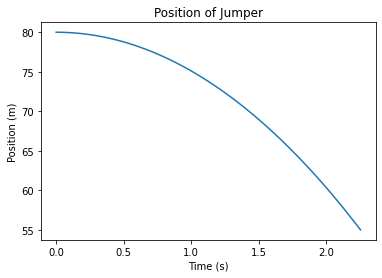

In [54]:
def plot_position(results,**options):
    results.y.plot(xlabel='Time (s)',
                   ylabel='Position (m)',
                  title='Position of Jumper',**options)
    
plot_position(results1)

We can use `min` to find the lowest point:

In [39]:
min(results1.y)

55.0

As expected, Phase 1 ends when the jumper reaches an altitude of 55 m.

## Phase 2

Once the jumper has fallen more than the length of the cord, acceleration due to energy transfer from the cord stops abruptly.  As the cord stretches, it starts to exert a spring force.  So let's simulate this second phase.

`spring_force` computes the force of the cord on the jumper:

In [40]:
def spring_force(y, system):
    """Computes the force of the bungee cord on the jumper:
    
    y: height of the jumper
    
    Uses these variables from system:
    y_attach: height of the attachment point
    L: resting length of the cord
    k: spring constant of the cord
    
    returns: force in N
    """
    L, k = system['L'], system['k']
    
    distance_fallen = system['y_attach'] - y
    extension = distance_fallen - L
    f_spring = k * extension
    return f_spring

The spring force is 0 until the cord is fully extended.  When it is extended 1 m, the spring force is 40 N. 

In [41]:
spring_force(55, system1)

0

In [42]:
spring_force(56, system1)

-40

The slope function for Phase 2 includes the spring force, and drops the acceleration due to the cord.

In [43]:
def slope_func2(t, state, system):
    """Compute derivatives of the state.
    
    state: position, velocity
    t: time
    system: System object containing g, rho,
            C_d, area, and mass
    
    returns: derivatives of y and v
    """
    y, v = state
    m_person, g = system['m_person'], system['g']
    
    a_drag = drag_force(v, system) / m_person
    a_spring = spring_force(y, system) / m_person
    dvdt = -g + a_drag + a_spring
    
    return v, dvdt

The initial state for Phase 2 is the final state from Phase 1.

In [44]:
t_final = results1.index[-1]
t_final

2.251931314077621

In [45]:
state_final = results1.iloc[-1]
state_final

y    55.000000
v   -22.385531
Name: 2.251931314077621, dtype: float64

And that gives me the starting conditions for Phase 2.

In [50]:
system2 = system1.copy()
system2.update(dict(t_0=t_final, init=state_final))

Here's how we run Phase 2, setting the direction of the event function so it doesn't stop the simulation immediately. 

In [51]:
results2, details2 = run_solve_ivp(system2, slope_func2)
details2.message

'The solver successfully reached the end of the integration interval.'

In [52]:
t_final = results2.index[-1]
t_final

8.0

We can plot the results on the same axes.

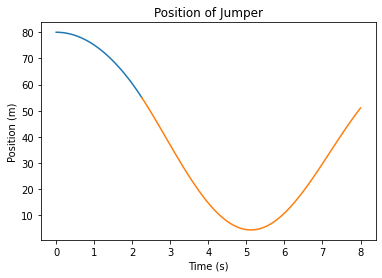

In [55]:
plot_position(results1, label='Phase 1')
plot_position(results2, label='Phase 2')

And get the lowest position from Phase 2.

In [56]:
min(results2.y)

4.430610945976474

To see how big the effect of the cord is, I'll collect the previous code in a function.

In [57]:
def run_two_phases(params):
    system1 = make_system(params)
    results1, details1 = run_solve_ivp(system1, slope_func1, 
                                       events=event_func1)
    t_final = results1.index[-1]
    state_final = results1.iloc[-1]
    
    system2 = system1.copy()
    system2.update(dict(t_0=t_final, init=state_final))
    results2, details2 = run_solve_ivp(system2, slope_func2)
    return results1.append(results2)

Now we can run both phases and get the results in a single `DataFrame`.

In [58]:
results = run_two_phases(params)

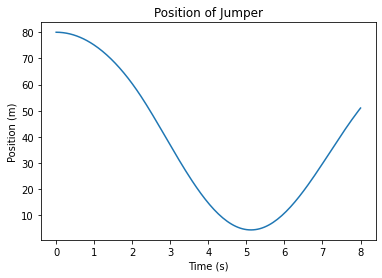

In [59]:
plot_position(results)

In [60]:
params_no_cord = params.copy()
params_no_cord.update(dict(m_cord=1))
results_no_cord = run_two_phases(params_no_cord);

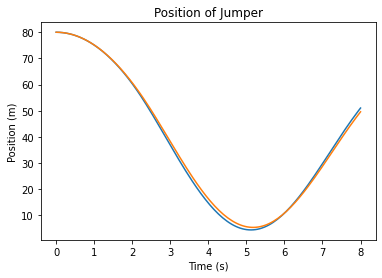

In [61]:
plot_position(results, label='m_cord = 75 kg')
plot_position(results_no_cord, label='m_cord = 1 kg')

In [62]:
min(results_no_cord.y)

5.398206928211416

In [63]:
diff = min(results.y) - min(results_no_cord.y)
diff

-0.9675959822349425

The difference is about a meter, which could certainly be the difference between a successful bungee dunk and a bad day.

In [114]:
results.iloc[90:150]
type('y')
isinstance('y',str)

True

y 80.0 v 0.0
numerator 0.0 denom 155.0
y 79.99751511358326 v -0.220689452986604
numerator 0.02435191732976325 denom 154.99751511358326
y 79.99006044189933 v -0.44138001099760404
numerator 0.09740815705412254 denom 154.99006044189935
y 79.97763594763691 v -0.6620727799849395
numerator 0.21917018299849306 denom 154.9776359476369
y 79.9602415684881 v -0.882768869560272
numerator 0.38964043853236024 denom 154.9602415684881
y 79.93787721713707 v -1.1034693932113198
numerator 0.6088223508770791 denom 154.93787721713707
y 79.91054248668603 v -1.3241760515595073
numerator 0.8767211077618635 denom 154.91054248668604
y 79.87823699833218 v -1.544890432076996
numerator 1.1933432235615238 denom 154.87823699833217
y 79.84096072687434 v -1.7656133780460221
numerator 1.5586953003675428 denom 154.84096072687436
y 79.79871360859278 v -1.9863457744816593
numerator 1.9727847679005714 denom 154.79871360859278
y 79.75149554085048 v -2.207088548925877
numerator 2.4356199313998665 denom 154.7514955408505
y 79

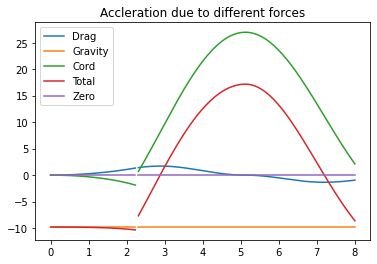

In [122]:
accel = pd.DataFrame([],index=results.index,
                     columns=["Drag","Gravity","Cord","Total","Zero"])
for t1 in results.index:
    y, v = results.loc[t1]
    if not isinstance(y,str):
        drag = drag_force(v,system1)/system1['m_person']
        grav = -9.8

        if y > 55:
            cord = cord_acc(y,v,system1)
        else:
            cord = spring_force(y,system1)/system1['m_person']
        total = drag + grav + cord
        accel.loc[t1]= [drag,grav,cord,total,0.0]
accel.plot(title='Accleration due to different forces');